In [1]:
#- Scientific stack
import numpy as np
import matplotlib.pyplot as plt
from dkps.dkps import DataKernelPerspectiveSpace

#- Transformers / embedding models
from sentence_transformers import SentenceTransformer
from datasets import load_dataset

import transformers
 
#- Utils
import gc
import torch
from tqdm import tqdm

In [2]:
#- get some toy data
n_queries=10
query_set = load_dataset("yahoo_answers_topics", split=f'train[:{n_queries}]', trust_remote_code=True)['question_title']
print(query_set[:2])

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'yahoo_answers_topics' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


README.md: 0.00B [00:00, ?B/s]

yahoo_answers_topics/train-00000-of-0000(…):   0%|          | 0.00/241M [00:00<?, ?B/s]

yahoo_answers_topics/train-00001-of-0000(…):   0%|          | 0.00/270M [00:00<?, ?B/s]

yahoo_answers_topics/test-00000-of-00001(…):   0%|          | 0.00/21.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

["why doesn't an optical mouse work on a glass table?", 'What is the best off-road motorcycle trail ?']


In [4]:
#- picking arbtirary foundation model.
if 'pipeline' not in locals():
    pipeline = transformers.pipeline(task='text-generation', model='meta-llama/Llama-3.1-8B-Instruct')
    pipeline.tokenizer.pad_token_id = 128009
    pipeline.tokenizer.padding_side='left'

generation_kwargs={
        'batch_size':10,
        'max_new_tokens':10,
        'eos_token_id':128009,
        'do_sample':True,
        'temperature':1,
        'num_return_sequences':5
}

message_list = [
    #- Shortening queries arbitrarily to make faster
    [{"role": "user", "content": q[:20]}] for q in query_set 
]

n_models = 5
system_prompt_list = ['You are a student.', 'You are a not a student.', 'You are a teacher.', 'You are not a teacher.']
output_dict = {}
for i, system_prompt in enumerate(system_prompt_list):
    message_list = [
        #- Shortening queries arbitrarily to make faster
        [{"role": "system", "content": system_prompt}, {"role": "user", "content": q[:20]}] for q in query_set 
    ]
    output_dict[system_prompt] = pipeline(message_list, **generation_kwargs)

Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.


In [7]:
if 'embedding_model' not in locals():
    embedding_model = SentenceTransformer('nomic-ai/nomic-embed-text-v1.5', trust_remote_code=True)


response_dict = {}
embedding_dict = {}
for i, system_prompt in enumerate(system_prompt_list):
    response_dict[system_prompt] = []
    embedding_dict[system_prompt] = []

    for j in range(n_queries):
        response_dict[system_prompt].append([o['generated_text'][-1]['content'] for o in output_dict[system_prompt][j]])
        embedding_dict[system_prompt].append(embedding_model.encode(response_dict[system_prompt][j]))
        
    embedding_dict[system_prompt] = np.array(embedding_dict[system_prompt])

In [9]:
dkps

{'You are a student.': array([-1.00693039,  4.13868798]),
 'You are a not a student.': array([-2.87376901,  0.34544432]),
 'You are a teacher.': array([ 6.58724137, -0.75065171]),
 'You are not a teacher.': array([-2.70654197, -3.73348059])}

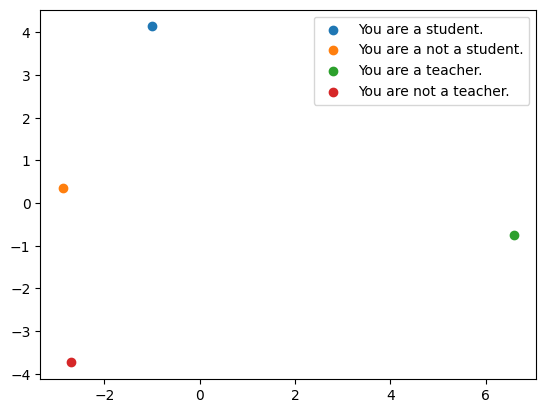

In [12]:
DKPS = DataKernelPerspectiveSpace(np.mean, 1, 'euclidean', None, 2)
dkps = DKPS.fit_transform(embedding_dict)

for system_prompt in system_prompt_list:
    plt.scatter(dkps[system_prompt][0], dkps[system_prompt][1], label=system_prompt)
plt.legend()